In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset/MRT.csv", parse_dates=True, index_col="DATE")
df.head(5)

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1992-01-01 to 2023-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   383 non-null    int64
dtypes: int64(1)
memory usage: 6.0 KB


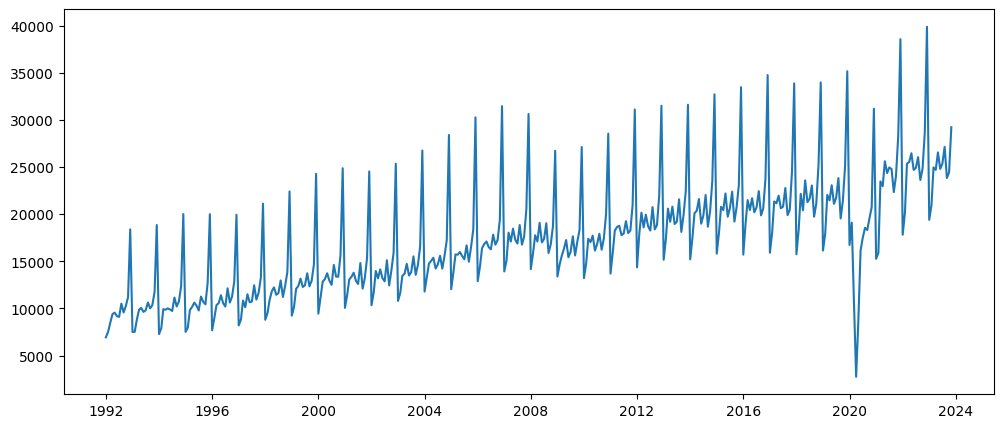

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df['Sales'])

In [5]:
size = 18
test_index = len(df) - size

train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [6]:
train.shape, test.shape

((365, 1), (18, 1))

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                length=length, batch_size=batch_size)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

n_features = 1

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [11]:
model.fit(generator, validation_data=val_generator, epochs=100, callbacks=[early_stop])

Epoch 1/100
353/353 [==============================] - 4s 7ms/step - loss: 0.0200 - val_loss: 0.0146
Epoch 2/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0142 - val_loss: 0.0060
Epoch 3/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 4/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 5/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0058 - val_loss: 0.0223
Epoch 6/100
353/353 [==============================] - 2s 7ms/step - loss: 0.0052 - val_loss: 8.1262e-04
Epoch 7/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 8/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 5.7985e-04
Epoch 10/100
353/353 [==============================] - 2s 6ms/step - loss: 0.0042 

In [12]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

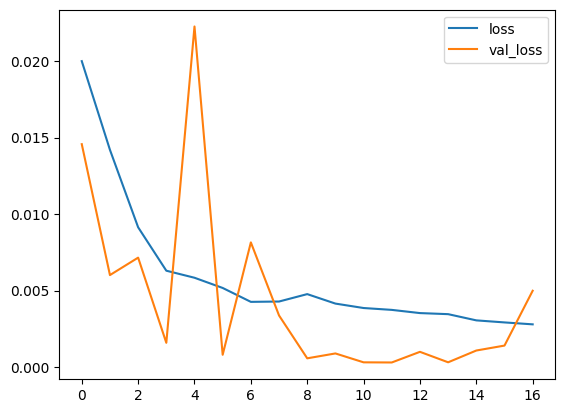

In [13]:
losses.plot()

In [14]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [15]:
true_predictions = scaler.inverse_transform(test_predictions)

C:\Users\younu\AppData\Local\Temp\ipykernel_21840\3954665995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='DATE'>

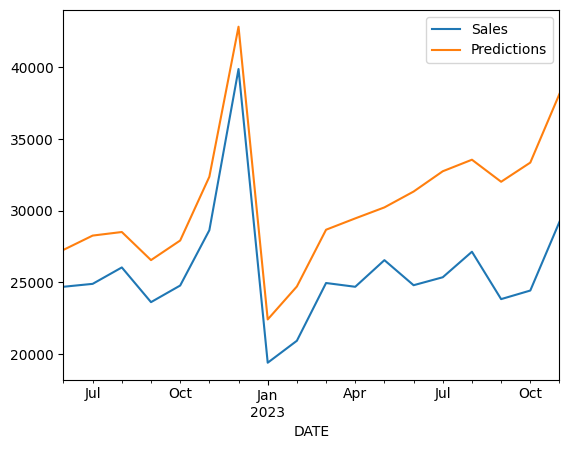

In [16]:
test['Predictions'] = true_predictions
test.plot()

## Train on full data

In [26]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=batch_size)

In [38]:
model = Sequential()
model.add(SimpleRNN(100, input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [39]:
model.fit(generator, epochs=10)

Epoch 1/10
371/371 [==============================] - 2s 4ms/step - loss: 0.0123
Epoch 2/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 3/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 4/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 5/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 6/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 7/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 8/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 9/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 10/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0077


In [40]:
df.tail()

,Sales
DATE,
2023-07-01,25364
2023-08-01,27143
2023-09-01,23840
2023-10-01,24438
2023-11-01,29227


In [41]:
forecast = []
period = length
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(period):
    current_pred = model.predict(current_batch, verbose=0)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [42]:
forecast = scaler.inverse_transform(forecast)

In [43]:
forecast_index = pd.date_range(start='2023-12-01', periods=period, freq="MS")
# forecast_index

In [44]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index, columns = ['Forcast'])
forecast_df.tail(4)

,Forcast
2024-08-01,16600.137680
2024-09-01,20738.562622
2024-10-01,22250.609171
2024-11-01,22687.688396


<AxesSubplot:xlabel='DATE'>

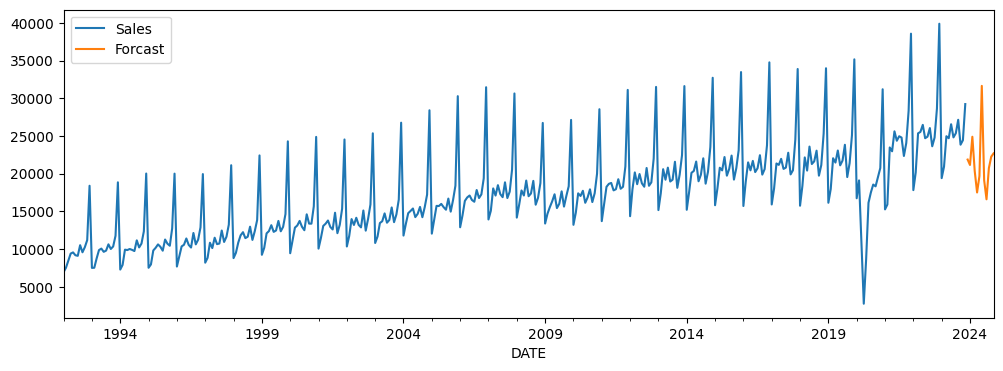

In [46]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,4))
# plt.xlim('2022-8-01','2024-11-01')